<a href="https://colab.research.google.com/github/kimheeseo/pytorch-RNN/blob/main/pytorch_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [350]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')#구글드라이브에서 파일 열기

Mounted at /content/gdrive


**데이터 셋 생성 및 전략**

In [351]:
df = pd.read_csv('/content/gdrive/MyDrive/code/stock.CSV',encoding='utf8')
df.head()#구글드라이브에 저장된 csv파일을 읽는다.

,date,start,high,low,close,volume
0,2019-07-17,39.73,39.75,39.4900,39.49,830640
1,2019-07-18,39.40,39.62,39.2700,39.59,621177
2,2019-07-19,39.83,39.83,39.3100,39.34,1026378
3,2019-07-22,39.42,39.56,39.3468,39.47,525941
4,2019-07-23,39.65,39.68,39.4100,39.68,673236


In [352]:
scaler = MinMaxScaler()
df[['start','high','low','close','volume']] = scaler.fit_transform(df[['start','high','low','close','volume']])
df.head()#시가인 start, 고가인 high, 저가인 low, 종가인 close, 거래량인 volue을 사용합니다.
#그리고 MinMaxScaler()를 통해, 최대최소정규화를 통해, 값들이 위의 값과 달리 1보다 작은 소수점이 나왔습니다.

,date,start,high,low,close,volume
0,2019-07-17,0.194733,0.186416,0.215947,0.198892,0.043649
1,2019-07-18,0.186760,0.183285,0.210726,0.201300,0.032642
2,2019-07-19,0.197149,0.188343,0.211675,0.195281,0.053935
3,2019-07-22,0.187243,0.181840,0.212549,0.198411,0.027638
4,2019-07-23,0.192800,0.184730,0.214048,0.203467,0.035378


In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    600 non-null    object 
 1   start   600 non-null    float64
 2   high    600 non-null    float64
 3   low     600 non-null    float64
 4   close   600 non-null    float64
 5   volume  600 non-null    float64
dtypes: float64(5), object(1)
memory usage: 28.2+ KB


In [354]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')#gpu 활성화를 위해서 사용하였습니다.

cpu is available


In [355]:
X = df[['start','high','low','volume']].values
y = df['close'].values

In [356]:
def seq_data(x, y, sequence_length):
  
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i: i+sequence_length])
    y_seq.append(y[i+sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

In [357]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
#보통 train과 test를 2:8로 설정하는 등의 방법으로 진행하는 데, 해당코드에서는 split을 활용했습니다.
#200을 기준으로 train과 test를 나눠서 구분하였고, sequence_length의 값은 5인데, 0~4까지의 값,
#즉 1~5일차까지의 데이터를 통해, 6일차의 데이터를 구하는 것을 확인할 수 있습니다.
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([395, 5, 4]) torch.Size([395, 1])


In [358]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20#딥러닝을 할 때 shuffle을 해줘야 좋은 학습이 되는데, 시계열이니, shuffle값은 false로 진행하지 않습니다.
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [359]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [360]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    return out
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [361]:
criterion = nn.MSELoss()

lr = 1e-3 #학습률
num_epochs = 500 #반복횟수 : epochs
optimizer = optim.Adam(model.parameters(), lr=lr) #optimizer는 여러개 중 Adam 사용

In [362]:
loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data 
    out = model(seq)   
    loss = criterion(out, target)#out과 target을 MSELoss로 구합니다.
#이 둘의 값을 비교하여, 성능평가를 할 수 있습니다.
    optimizer.zero_grad() #다음 아래코드는 train할 때 사용하는 공식화 된 구조
    loss.backward() #loss 최소화 
    optimizer.step() #가중치 업데이트
    running_loss += loss.item() # 한 배치의 loss 더해주고,

#running_loss/n을 하는 이유는 전체 중 오류가 몇퍼센트인지 구하기 위해서 사용.
  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  if epoch % 50 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.0625
[epoch: 50] loss: 0.0017
[epoch: 100] loss: 0.0007
[epoch: 150] loss: 0.0007
[epoch: 200] loss: 0.0006
[epoch: 250] loss: 0.0006
[epoch: 300] loss: 0.0005
[epoch: 350] loss: 0.0005
[epoch: 400] loss: 0.0004
[epoch: 450] loss: 0.0004


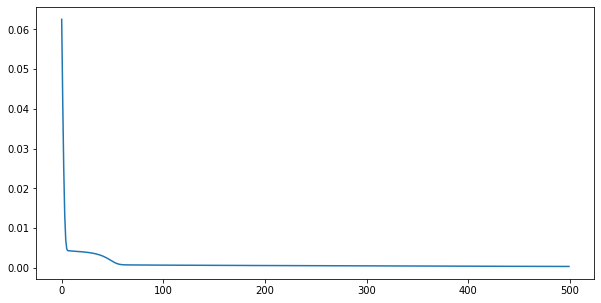

In [363]:
plt.figure(figsize=(10,5))
plt.plot(loss_graph)
plt.show()

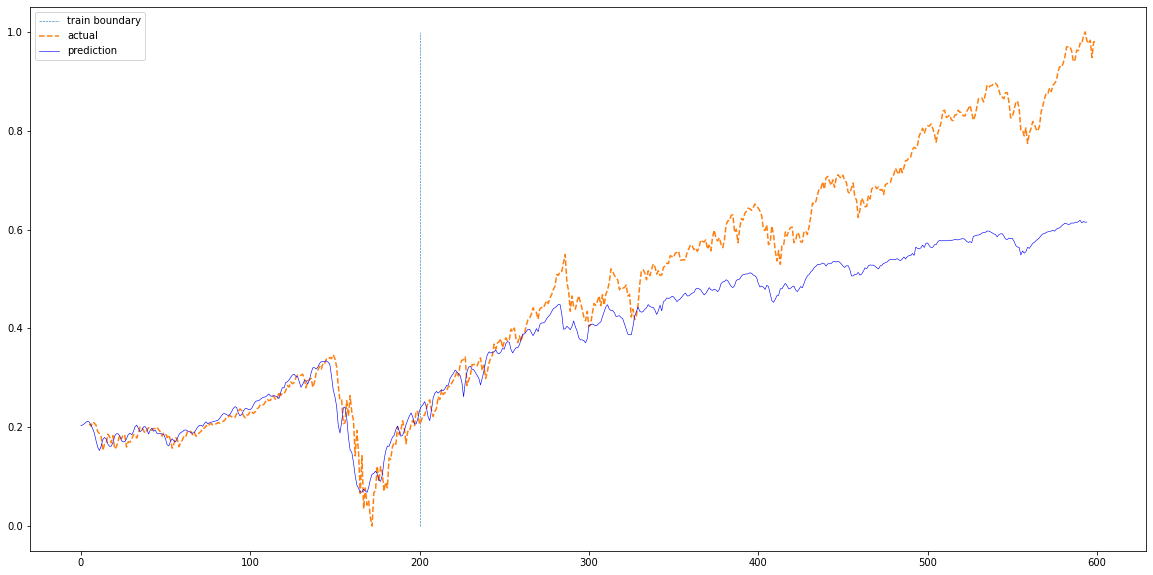

In [364]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []
#plotting으로 그래프를 그립니다.
    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)
#total은 "train_pred+test_pred"으로 되어 있는데, 이 값은 pred들의 값이기에,
#예측값인 Prediction의 값들을 나타낸 값입니다.

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()
#close인 결과값을 통해, 성능평가를 합니다.
plotting(train_loader, test_loader, df['close'][sequence_length:])